In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import time
import math
import pickle

In [3]:
filename_Xtrain = '../data/X_train.csv'
filename_ytrain = '../data/y_train.csv'
filename_Xtest = '../data/X_test.csv'
filename_ytest = '../data/y_test.csv'

# Set Pandas to show all the columns
pd.set_option('display.max_columns', None)

# Read the data as a dataframe
X_train = pd.read_csv(filename_Xtrain)
y_train = pd.read_csv(filename_ytrain)

X_test = pd.read_csv(filename_Xtest)
y_test = pd.read_csv(filename_ytest)

In [4]:
y_train = y_train.iloc[:,0]
y_test = y_test.iloc[:,0]

### Decision of parameters

After studying the different hyperparameters that can be passed as argument to this model, we selected to adjust the "n_neighbors" and we will do so using Grid Search Cross Validation

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix

In [6]:
from sklearn.neighbors import KNeighborsClassifier

time of training: 5.381409804026286 minutes 

best mean cross-validation score: 0.587
best parameters: {'n_neighbors': 47}


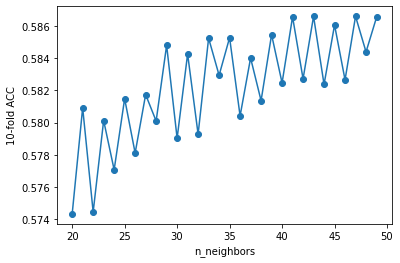

In [7]:
startTime = time.time()

n_neighbors = range(20,50)

param_grid = {'n_neighbors': n_neighbors}

grid = GridSearchCV(KNeighborsClassifier(metric = 'euclidean'), 
                      param_grid = param_grid,
                      cv = 10)

grid.fit(X_train, y_train)

endTime = time.time()
print(f"time of training: {(endTime - startTime)/60} minutes \n")

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(n_neighbors,scores,'-o')
plt.xlabel('n_neighbors')
plt.ylabel('10-fold ACC')

plt.show()

We appreciate a weird pattern here. We see that the accuracy is pretty much the same for n_neighbors = 41 or 43. However, we keep n_neighbors = 47  because the for this model, the higher the parameter, the better the model will perform.

### Train with the best parameters

In [8]:
kOptimo = grid.best_params_['n_neighbors']

knnModel = KNeighborsClassifier(n_neighbors =kOptimo, metric = 'euclidean')
knnModel.fit(X_train,y_train)

print("Train: ",knnModel.score(X_train,y_train))
print("Test: ",knnModel.score(X_test,y_test))

Train:  0.6190446161122497
Test:  0.5974271660991298


### Save the model

In [10]:
filename = '../models/knn.sav'
pickle.dump(knnModel, open(filename, 'wb'))

### Load the model

In [11]:
# load the model from disk
filename = '../models/knn.sav'
knnModel = pickle.load(open(filename, 'rb'))
result = knnModel.score(X_test, y_test)
print(result)

0.5974271660991298


### Evaluate the model


--> The classification report is: 
               precision    recall  f1-score   support

         0.0       0.57      0.53      0.55      3684
         1.0       0.62      0.66      0.64      4245

    accuracy                           0.60      7929
   macro avg       0.59      0.59      0.59      7929
weighted avg       0.60      0.60      0.60      7929



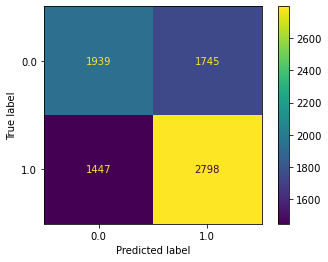

In [12]:
predictionsKnn = knnModel.predict(X_test)
print("\n--> The classification report is: \n", classification_report(y_test, predictionsKnn))
plot_confusion_matrix(knnModel, X_test, y_test)

We see that the recall is lower than for the tree-based models and so is the accuracy. It seems that it is not being able to predict better whether an article will be popular or not. 

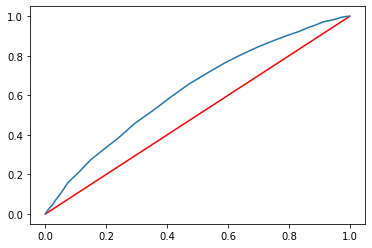

The AUC score is: 0.6260233985438575


In [13]:
probsKnn = knnModel.predict_proba(X_test)[:,1]

base_fpr, base_tpr,_ = roc_curve(y_test, [1 for _ in range(len(y_test))])
plt.plot(base_fpr, base_tpr, color = 'r')

fpr,tpr,_ = roc_curve(y_test, probsKnn)
plt.plot(fpr,tpr)

plt.show()
print("The AUC score is:", roc_auc_score(y_test,probsKnn))

We can see that we are pretty close to the baseline, that represents the worst scenario in which the decision will be done at random